<a href="https://colab.research.google.com/github/kirill-rubashevskiy/expf-statistics-ab/blob/main/cuped/cuped.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Применение $CUPED$ для снижения дисперсии метрики



## Описание данных

Данные содержат метрику эксперимента в тестовом варианте и 6 ковариат. Все ковариаты отличаются по описательным характеристикам (среднее, дисперсия) и имеют разную связь с метрикой (положительная и отрицательная):

- `metric` – значения метрики эксперимента
- с `covariate1` по `covariate6` – ковариаты.

## Задача

Посчитать $CUPED$ для 6 ковариат и ответить на следующие вопросы:

1. Снижает ли $CUPED$ дисперсию метрики, если $\theta = 0$?
2. Снижает ли $CUPED$ дисперсию метрики, если у ковариаты экстремально большая дисперсия (в разы больше, чем у метрики)?
3. Возможно ли снизить дисперсию метрики до нуля?
4. Всегда ли $CUPED$ снижает дисперсию метрики?

## Подготовка к работе

In [1]:
# импорт библиотек

# общие, работа с данными
import os
import six
import warnings
import numpy as np
import pandas as pd

# визуализация данных
import seaborn as sns
import matplotlib.pyplot as plt

# статистические инструменты
import statsmodels.formula.api as smf

# ML-модели
from sklearn.linear_model import LinearRegression

In [2]:
# настройка отображения графиков
plt.style.use('fivethirtyeight')

# настройка отображения предупреждений
warnings.filterwarnings('ignore', category = FutureWarning)

## Загрузка данных

In [3]:
# подключение google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# указание пути к данным
PATH = '/content/drive/MyDrive/expf/cuped'

In [5]:
# чтение данных
data = pd.read_csv(filepath_or_buffer = os.path.join(PATH, 'hw_6.csv'),
                   sep                = ';',
                   index_col          = 0,
                   decimal            = ',')

In [6]:
# вывод на экран первых десяти строк датасета
data.head(10)

,metric,covariate1,covariate2,covariate3,covariate4,covariate5,covariate6
1,28,23,1,28,28,28,1
2,30,22,3,26,27,30,30
3,33,20,2,23,26,33,20
4,31,24,3,25,31,31,30
5,34,26,3,23,26,34,30
6,29,20,3,28,27,29,30
7,35,23,2,20,25,35,20
8,33,22,3,22,22,33,30
9,30,19,3,25,27,30,300


- мы видим, что метрика дискретная

In [7]:
# вывод на экран общей информации о датасете
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9 entries, 1 to 9
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   metric      9 non-null      int64
 1   covariate1  9 non-null      int64
 2   covariate2  9 non-null      int64
 3   covariate3  9 non-null      int64
 4   covariate4  9 non-null      int64
 5   covariate5  9 non-null      int64
 6   covariate6  9 non-null      int64
dtypes: int64(7)
memory usage: 576.0 bytes


## EDA

Изучим распределения значений метрики и ковариат и их зависимость:

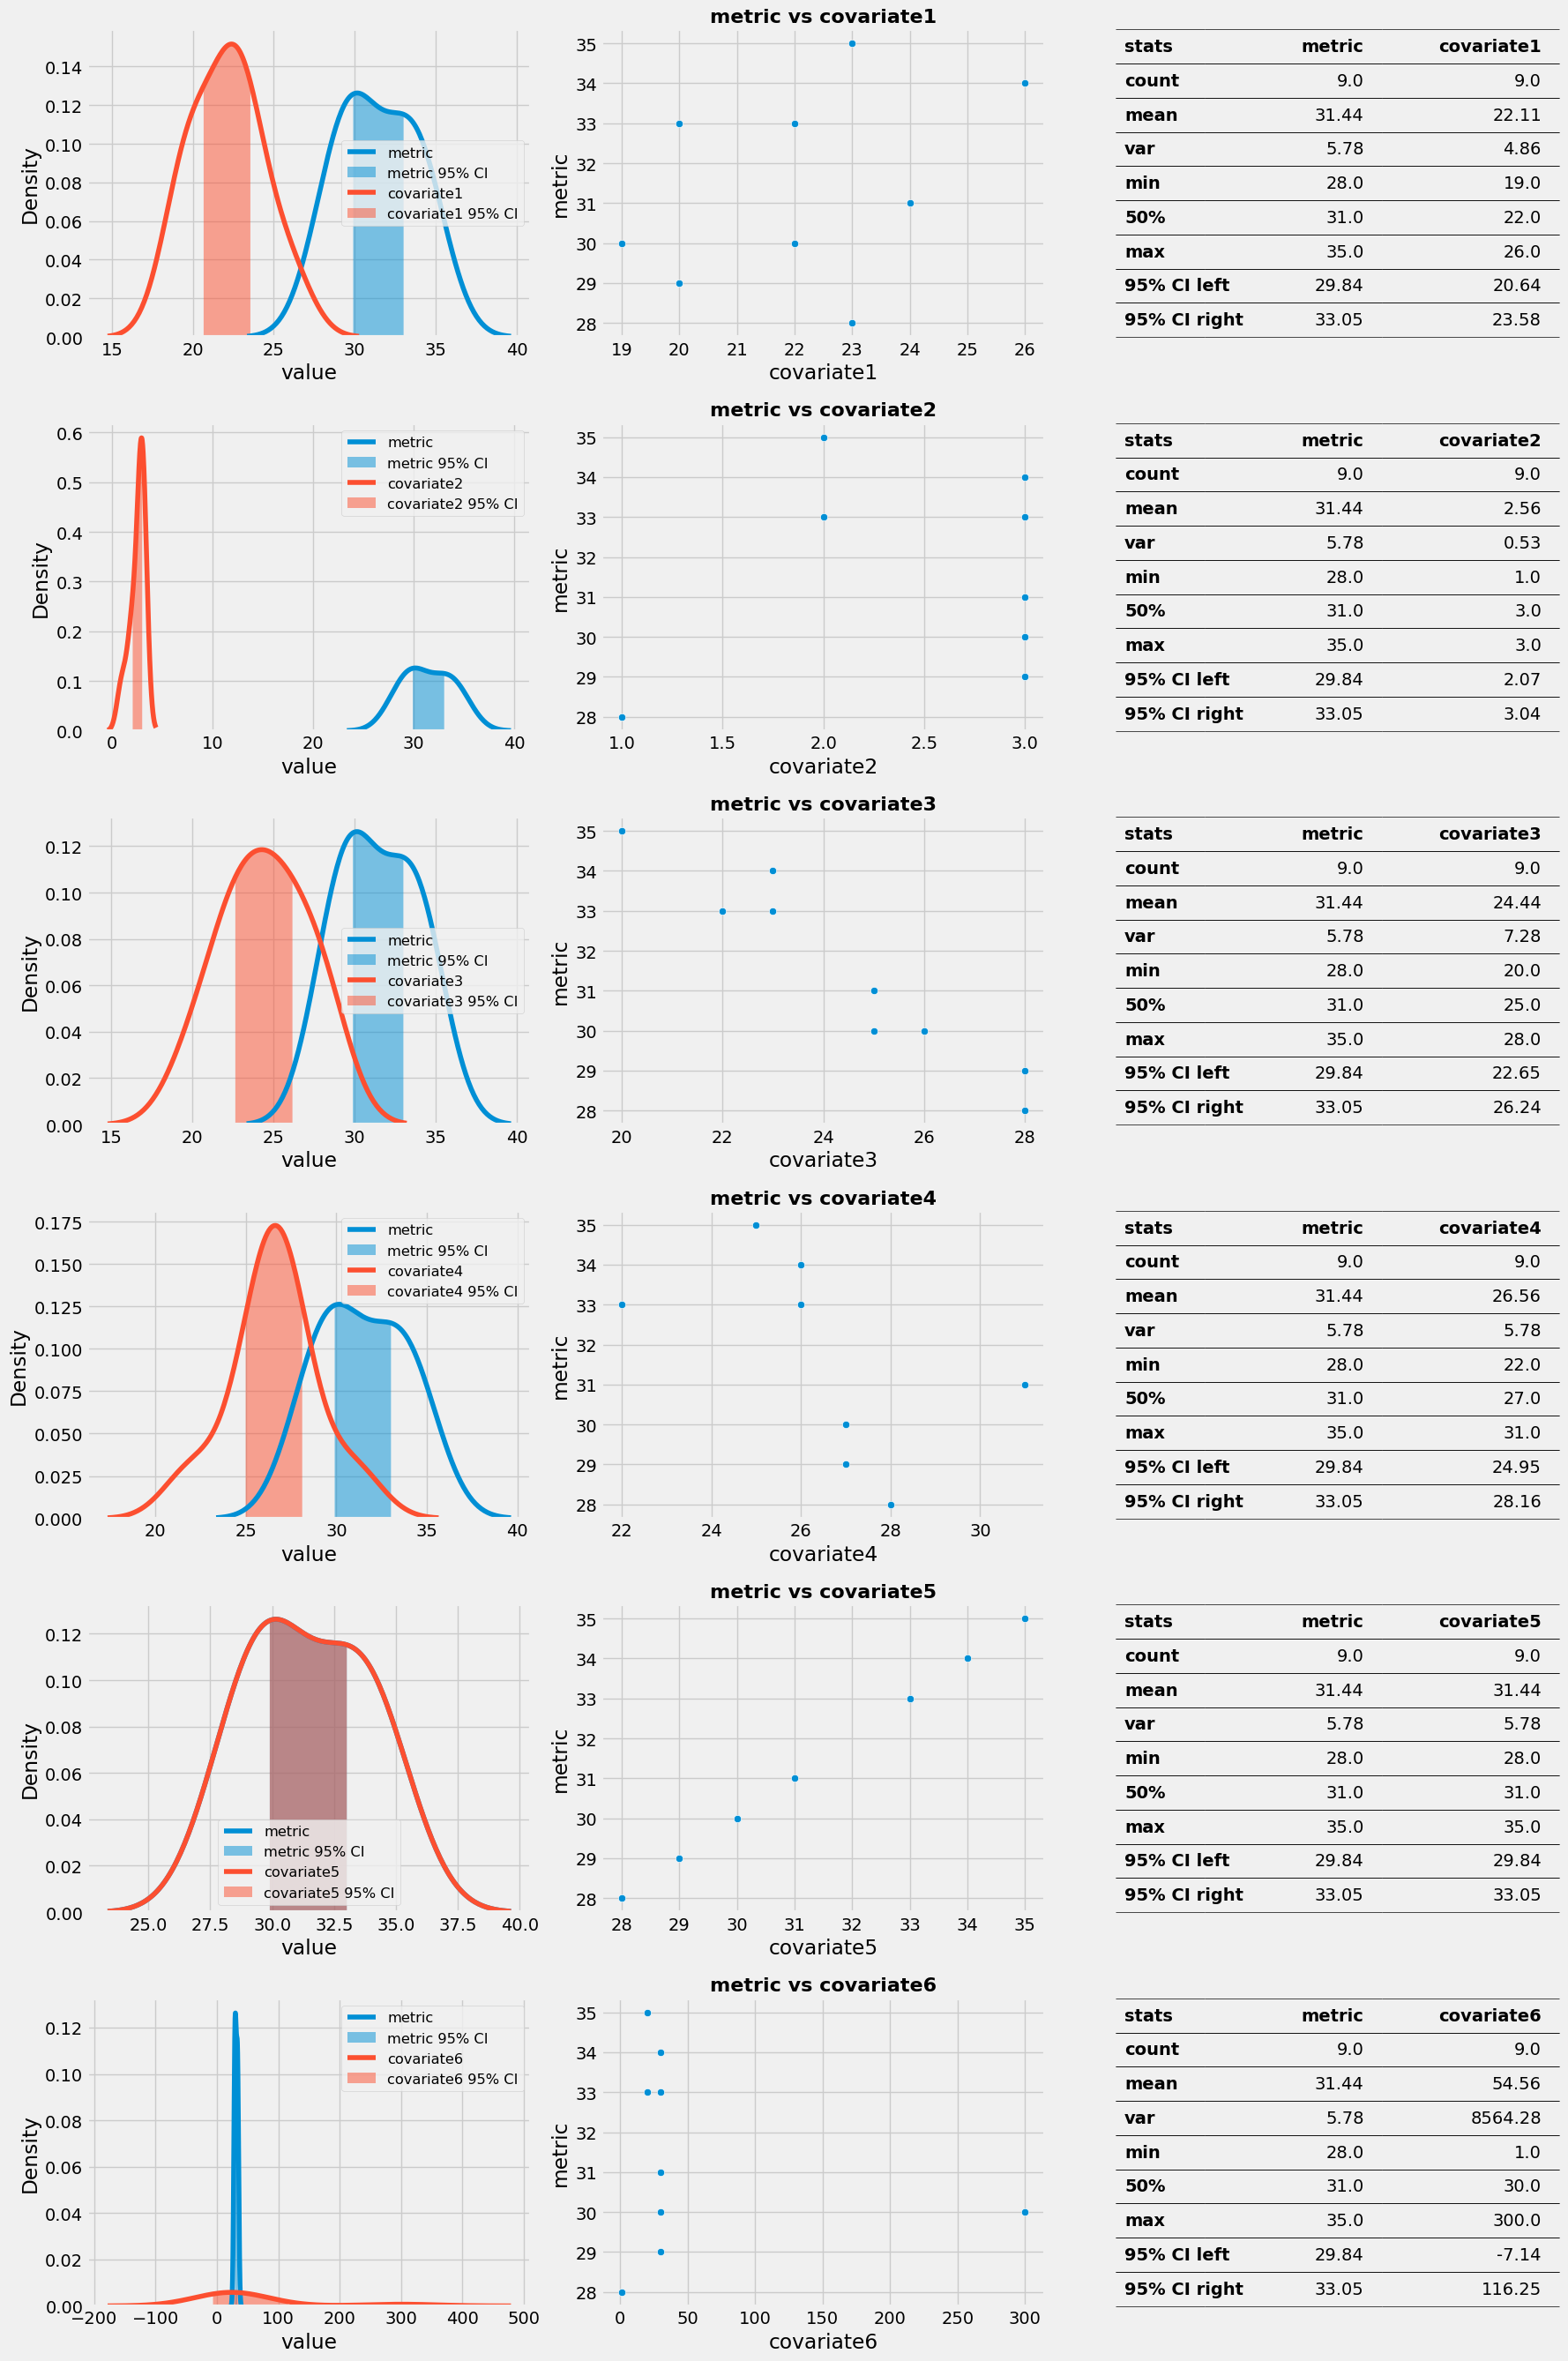

In [8]:
# вывод на экран графиков и статистик распределения значений
# метрики и ковариат
fig, ax = plt.subplots(nrows   = 6,
                       ncols   = 3,
                       figsize = (18, 27))

for i, cov in enumerate(data.columns[1:7]):

    cis_left = []
    cis_right = []

    cov_data = data[['metric', cov]]

    for variant in cov_data.columns:

        variant_data = cov_data[variant]

        mean_ = np.mean(variant_data)
        std_ = np.std(variant_data, ddof = 1)
        se_   = std_ / np.sqrt(len(variant_data))

        g = sns.kdeplot(variant_data,
                        label = variant,
                        ax    = ax[i][0])

        x = g.lines[-1].get_xdata()
        y = g.lines[-1].get_ydata()

        ci_left = mean_ - se_ * 2
        ci_right = mean_ + se_ * 2

        cis_left.append(np.round(ci_left, 2))
        cis_right.append(np.round(ci_right, 2))

        g.fill_between(x,
                    y,
                    0,
                    where = (x > ci_left) & (x < ci_right),
                    alpha = 0.5,
                    label = f'{variant} 95% CI')

    ax[i][0].set_xlabel('value')
    ax[i][0].legend(fontsize = 'small')

    sns.scatterplot(data = cov_data,
                    x    = cov,
                    y    = 'metric',
                    ax   = ax[i][1])

    ax[i][1].set_title(f'metric vs {cov}', fontsize = 16, fontweight = 'bold')

    feature_stats = cov_data.describe().round(2).reset_index()

    feature_stats.rename(columns = {'index' : 'stats'},
                         inplace = True)

    feature_stats.iloc[2, 0] = 'var'
    feature_stats.iloc[2, 1:] = cov_data.var().round(2)

    feature_stats.loc[len(feature_stats.index)] = ['95% CI left'] + cis_left
    feature_stats.loc[len(feature_stats.index)] = ['95% CI right'] + cis_right

    feature_stats = feature_stats.iloc[[0, 1, 2, 3, 5, 7, 8, 9], :]

    the_table = ax[i][2].table(cellText  = feature_stats.values,
                               colLabels = feature_stats.columns,
                               bbox      = (0, 0, 1, 1),
                            colWidths = [0.2, 0.4, 0.4],
                            edges     = 'horizontal')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)

    for k, cell in six.iteritems(the_table._cells):
        if k[1] == 0: cell.set_text_props(ha = 'left')
        else: cell.set_text_props(ha = 'right')
        if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

    ax[i][2].axis('off')

plt.tight_layout()
plt.show()

Мы видим, что:
- базовая дисперсия метрики – 5.78, дисперсия ковариат варьируется от 0.53 (у ковариаты 2) до 8564.28 (у ковариаты 6);
- у двух ковариат (4 и 5) дисперсия совпадает с дисперсией метрики;
- ковариаты 3 и 5 демонстрируют линейную связь с метрикой;
- ковариата 5 полностью совпадает с метрикой.


## $CUPED$-трансформация



Трансформируем значения метрики с использованием метода $CUPED$ и ковариат:

In [9]:
# для каждой ковариаты применение CUPED для трансформации исходной метрики
Y = data['metric']

for i, cov in enumerate(data.columns[1:], 1):
    X = data[[cov]]
    X_mean = np.mean(X.values)
    theta = LinearRegression().fit(X, Y).coef_[0]
    data[f'metric_cuped{i}'] = data['metric'] - theta * (data[cov] - X_mean)

Проанализируем результаты трансформации:

<ipython-input-10-92fe5ab4f7b3>:19: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  g = sns.kdeplot(variant_data,


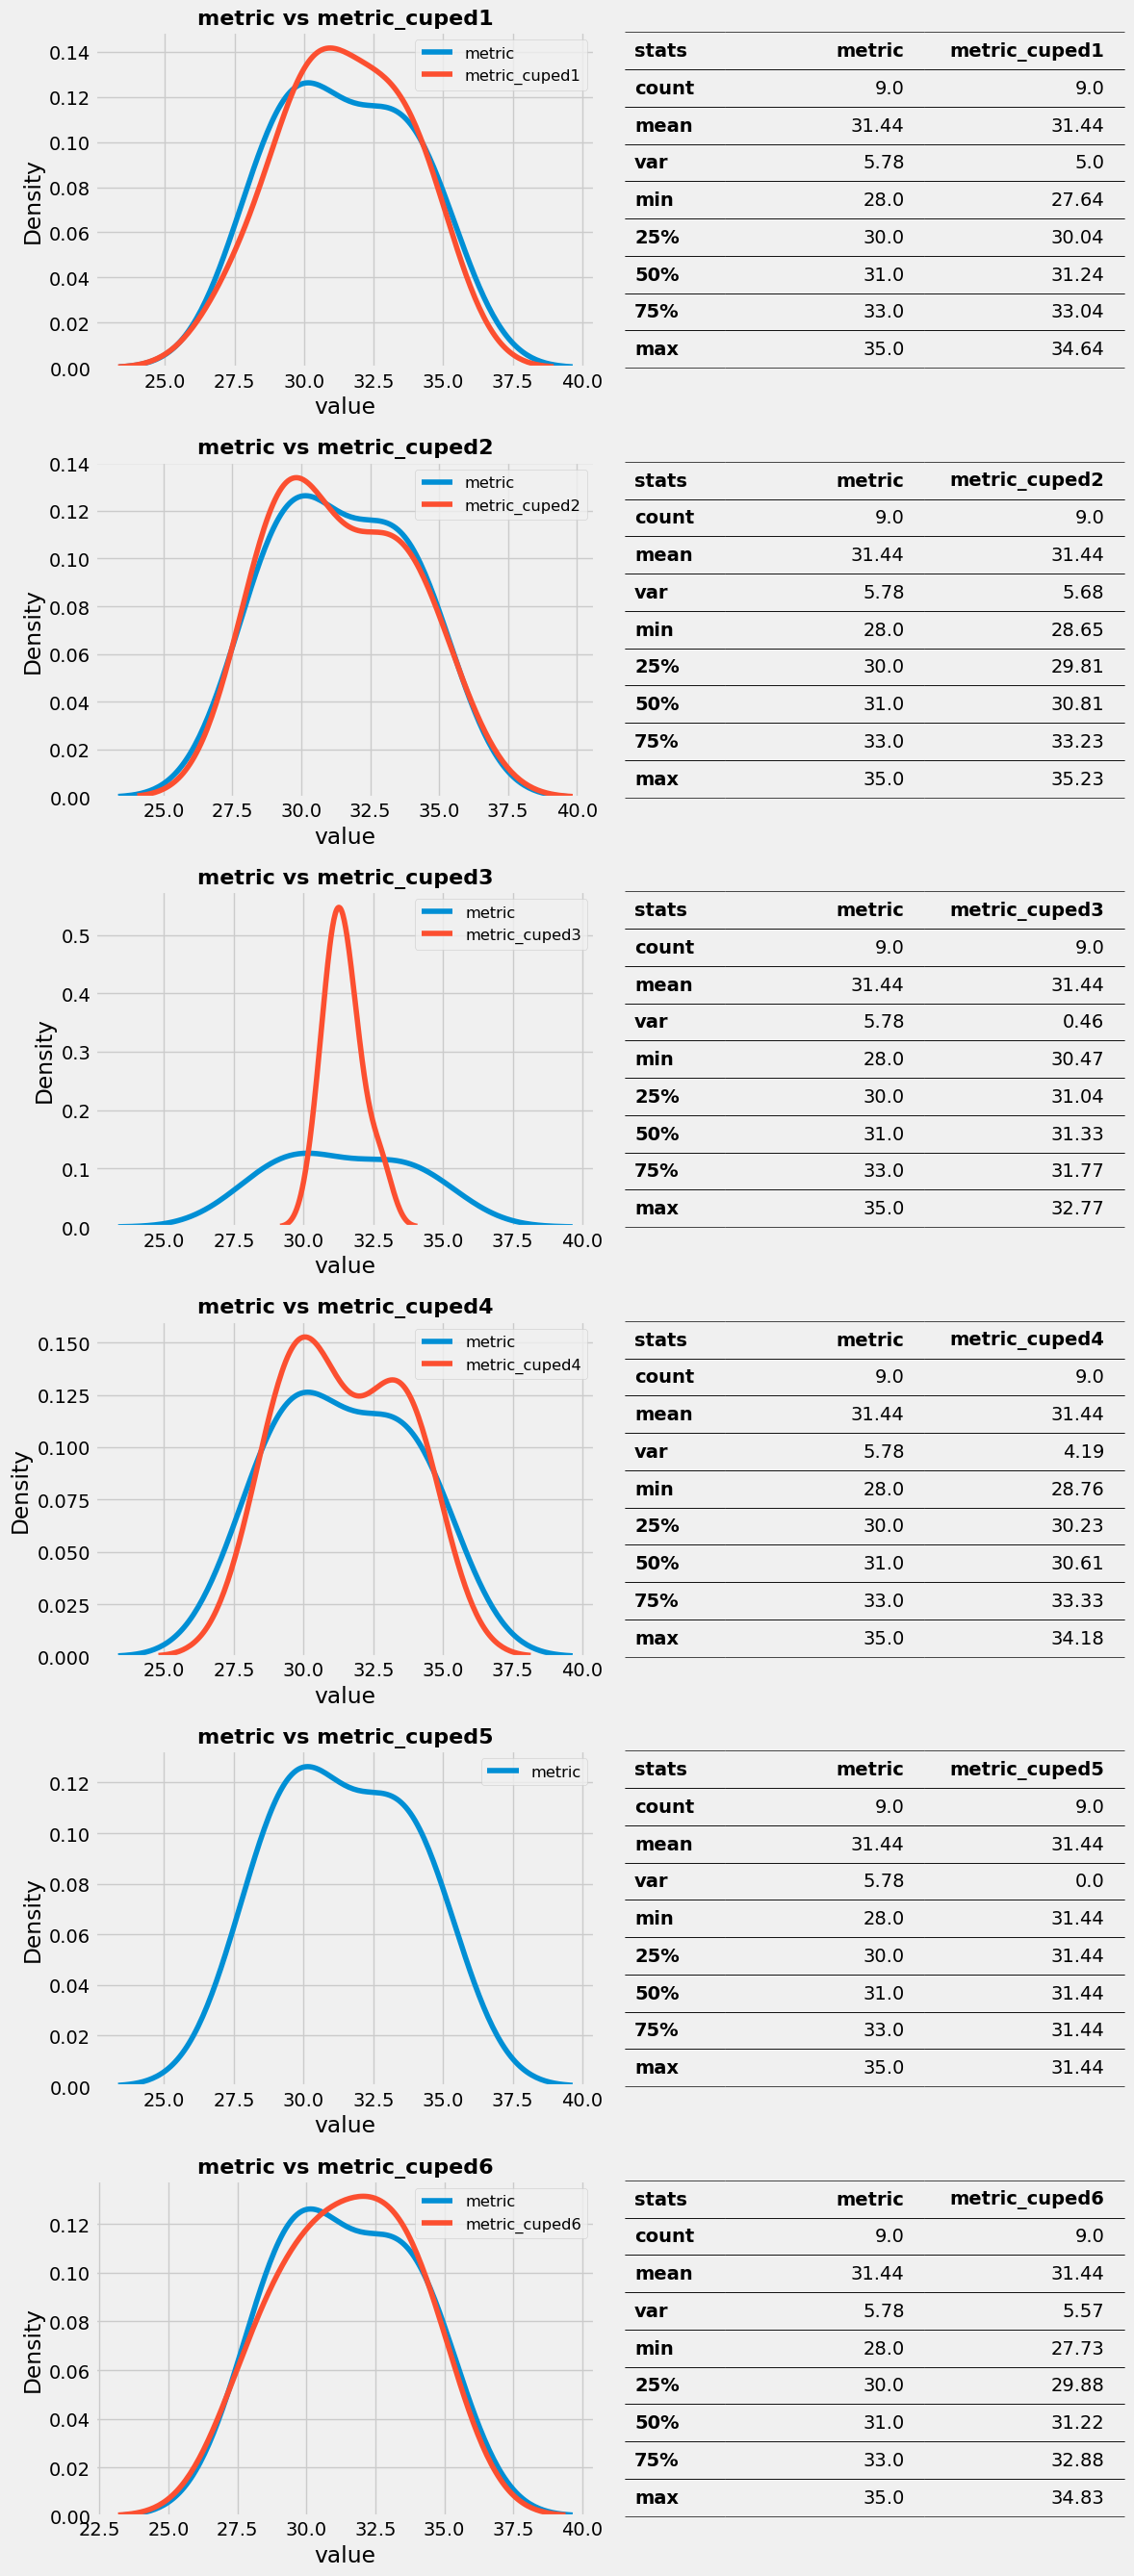

In [10]:
# вывод на экран графиков и статистик распределения значений
# исходной метрики и метрик, трансформированных при помощи CUPED
fig, ax = plt.subplots(nrows   = 6,
                       ncols   = 2,
                       figsize = (12, 27))

for i, cov in enumerate(data.columns[7:]):

    cov_data = data[['metric', cov]]

    for variant in cov_data.columns:

        variant_data = cov_data[variant]

        mean_ = np.mean(variant_data)
        std_ = np.std(variant_data, ddof = 1)
        se_   = std_ / np.sqrt(len(variant_data))

        g = sns.kdeplot(variant_data,
                        label = variant,
                        ax    = ax[i][0])

    ax[i][0].set_xlabel('value')
    ax[i][0].legend(fontsize = 'small')
    ax[i][0].set_title(f'metric vs {cov}', fontsize = 16, fontweight = 'bold')

    feature_stats = cov_data.describe().round(2).reset_index()
    feature_stats.rename(columns = {'index' : 'stats'},
                     inplace = True)

    feature_stats.iloc[2, 0] = 'var'
    feature_stats.iloc[2, 1:] = cov_data.var().round(2)

    the_table = ax[i][1].table(cellText  = feature_stats.values,
                            colLabels = feature_stats.columns,
                            bbox      = (0, 0, 1, 1),
                            colWidths = [0.2, 0.4, 0.4],
                            edges     = 'horizontal')

    the_table.auto_set_font_size(False)
    the_table.set_fontsize(14)

    for k, cell in six.iteritems(the_table._cells):
        if k[1] == 0: cell.set_text_props(ha = 'left')
        else: cell.set_text_props(ha = 'right')
        if k[0] == 0 or k[1] == 0: cell.set_text_props(weight = 'bold')

    ax[i][1].axis('off')



plt.tight_layout()
plt.show()

Мы видим, что:
- независимо от выбранной для ковариаты среднее значение метрики после трансформации не изменилось;
- наибольшее снижение дисперсии метрики показали трансформации с использованием наиболее коррелирующих с метрикой ковариат 3 и 5;
- даже в случае использования ковариаты 6 с экстремально большой дисперсией дисперсия трансформированной метрики снизилась.

### Выводы

**Снижает ли $CUPED$ дисперсию метрики, если $\theta = 0$?**

Нет. Исходя из формулы $CUPED$ в этом случае распределение метрики после трансформации будет полностью совпадать с ее распределением до трансформации, следовательно, дисперсия метрики также не изменится.

**Снижает ли $CUPED$ дисперсию метрики, если у ковариаты экстремально большая дисперсия (в разы больше, чем у метрики)?**

Мы эмпирически установили что при определенных обстоятельствах $CUPED$ снижает дисперсию метрики даже если у ковариаты экстремально большая дисперсия (в разы больше, чем у метрики). Главное, чтобы ковариация метрики и коварианты не равнялась нулю.

**Возможно ли снизить дисперсию метрики до нуля?**

Да, в случае, если распределение значений ковариаты полностью совпадает с распределением метрики (в этом случае вся дисперсия метрики полностью объясняется предыдущими наблюдениями).

**Всегда ли $CUPED$ снижает дисперсию метрики?**

Нет, $CUPED$ не будет снижать дисперсию в случае, если, например, ковариация между ковариатой и метрикой равна нулю. С другой стороны, если ковариата представляет собой предыдущее поведение метрики, допустить, что она и метрика полностью независимы, достаточно сложно.